# Analyse du portfolio yahooFinance

D'abord, on importe tout ce qu'il faut

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.express as px
import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

On importe le portfolio télechargé sur yahoo finance, puis on le trie par la date de chaque achat.

In [2]:
portfolio = pd.read_csv('quotes.csv')
portfolio = portfolio.sort_values(by=['Trade Date']).reset_index()

In [3]:
portfolio

,index,Symbol,Current Price,Date,Time,Change,Open,High,Low,Volume,Trade Date,Purchase Price,Quantity,Commission,High Limit,Low Limit,Comment
0,10,ABBV,108.540000,2021/10/25,15:52 EDT,-0.599998,109.080000,109.080000,107.750000,3101384,20200729.0,97.090,5.0000,NaN,NaN,85.0,NaN
1,15,OKE,65.850000,2021/10/25,15:52 EDT,1.040001,65.390000,65.990000,65.195000,1209791,20200729.0,26.720,16.0000,NaN,NaN,NaN,NaN
2,13,MSFT,308.490000,2021/10/25,15:52 EDT,-0.670013,309.360000,309.380000,306.460000,12572639,20200824.0,213.250,1.0000,NaN,NaN,NaN,NaN
3,6,UST.PA,52.750000,2021/10/25,17:35 CEST,0.403999,52.432000,52.750000,52.350000,8106,20200909.0,37.640,27.0000,NaN,NaN,NaN,NaN
4,14,MSFT,308.490000,2021/10/25,15:52 EDT,-0.670013,309.360000,309.380000,306.460000,12572639,20201230.0,222.060,3.0000,NaN,NaN,NaN,NaN
5,7,ORA.PA,9.605000,2021/10/25,17:37 CEST,-0.061001,9.655000,9.687000,9.575000,8071515,20210108.0,10.325,100.0000,NaN,NaN,NaN,NaN
6,17,TSM,113.575000,2021/10/25,15:52 EDT,-0.655006,114.400000,114.549900,113.110000,4294754,20210119.0,131.190,5.0000,NaN,NaN,NaN,NaN
7,9,V,233.902000,2021/10/25,15:52 EDT,2.671997,233.450000,234.860000,232.300000,3951525,20210201.0,197.000,5.0000,NaN,NaN,NaN,NaN
8,8,MA,360.630000,2021/10/25,15:52 EDT,1.959992,362.460000,364.300000,358.792500,1953033,20210201.0,315.000,3.0000,NaN,NaN,NaN,NaN
9,11,ABBV,108.540000,2021/10/25,15:52 EDT,-0.599998,109.080000,109.080000,107.750000,3101384,20210203.0,108.920,5.0000,NaN,NaN,NaN,NaN


Il y a deux lignes particulières : celle du NASDAQ (ticker UST.PA) qui servira de référence, et celle du taux de change euro-dollar pour comparer les investissements en euro. Identifions les:

In [4]:
ref_idx = np.where(portfolio['Symbol']=='UST.PA')[0][0]
fx_idx = np.where(portfolio['Symbol']=='EURUSD=X')[0][0]

On récupère ensuite les données historiques sur 5 ans avec une résolution d'un jour via l'API yfinance:

In [5]:
tickers = [yf.Ticker(symbol) for symbol in portfolio['Symbol']]

histories = [ticker.history('5y') for ticker in tickers]
for history in histories:
    dividends = history['Dividends'].cumsum()
    for col in ['Open', 'High', 'Low', 'Close']:
        history[col] = history[col] + dividends

### Définitions de quelques fonctions:

In [6]:
def tradedate_2_dtime(td):
    """ convert trade date as formatted by yfinance to a datetime object """
    td_str = str(int(td))
    y, m, d = int(td_str[:4]), int(td_str[4:6]), int(td_str[6:])
    return datetime(y, m, d)

In [7]:
    def convert_to_usd(ticker_df, forex_df):
        """ convert history dataframe of a ticker with a forex history dataframe """
        common_index = ticker_df.index.intersection(forex_df.index)
        ticker_common = ticker_df.loc[common_index]
        forex_common = forex_df.loc[common_index]
        for col in ['Open', 'High', 'Low', 'Close', 'Dividends']:
            ticker_common[col] = ticker_common[col] * forex_common[col]
        return ticker_common

In [8]:
def ticker_2_priceevol(ticker_df, trade_date, forex_df=[]):
    """ for a given yf history and trade date (datetime), return the time/price date over the holding period.
    forex conversion is performed if a forex history is given """
    if len(forex_df)!=0:
        ticker_df = convert_to_usd(ticker_df, forex_df)
    ticker_df_ri = ticker_df.reset_index()
    date = ticker_df_ri['Date']
    price = ticker_df_ri['Close']
    since_trade = date - trade_date
    has_bought = since_trade > timedelta(0)
    T, P = date[has_bought], price[has_bought]
    
    return T, P

In [9]:
def ratio_to_reference(ticker_df, ref_df, trade_date):
    """ compute the ratio between a given ticker (history) and a reference ticker (history), at trade date """
    return ticker_df.loc[trade_date, 'Close'] / ref_df.loc[trade_date, 'Close']

In [10]:
def scale_data(ticker_df, ref_df, trade_date, forex):
    """ scale ticker (history) to ref ticker (history) so the time/price series of the tickers 'stems' from the ref plot """
    initial_ratio = ratio_to_reference(ticker_df, ref_df, trade_date)
    #print(initial_ratio)
    T, P = ticker_2_priceevol(ticker_df, trade_date, forex)
    return T, P/initial_ratio

### On converti les cours en euros
(y compris la réf, le nasdaq, acheté sur un fond euro)

In [11]:
forex = histories[fx_idx]

for i, (ticker_df, symbol) in enumerate(zip(histories, portfolio['Symbol'])): 
    try:
        trade_date = tradedate_2_dtime(portfolio.loc[i, 'Trade Date'])
    except ValueError:
        continue       
    if ".PA" in symbol:
        histories[i] = convert_to_usd(ticker_df, forex)

### Calcul et plot des séries temporelles
On calcule les séries time/price collapsée à la référence (nasdaq)

UST.PA 2020-09-09 00:00:00 3


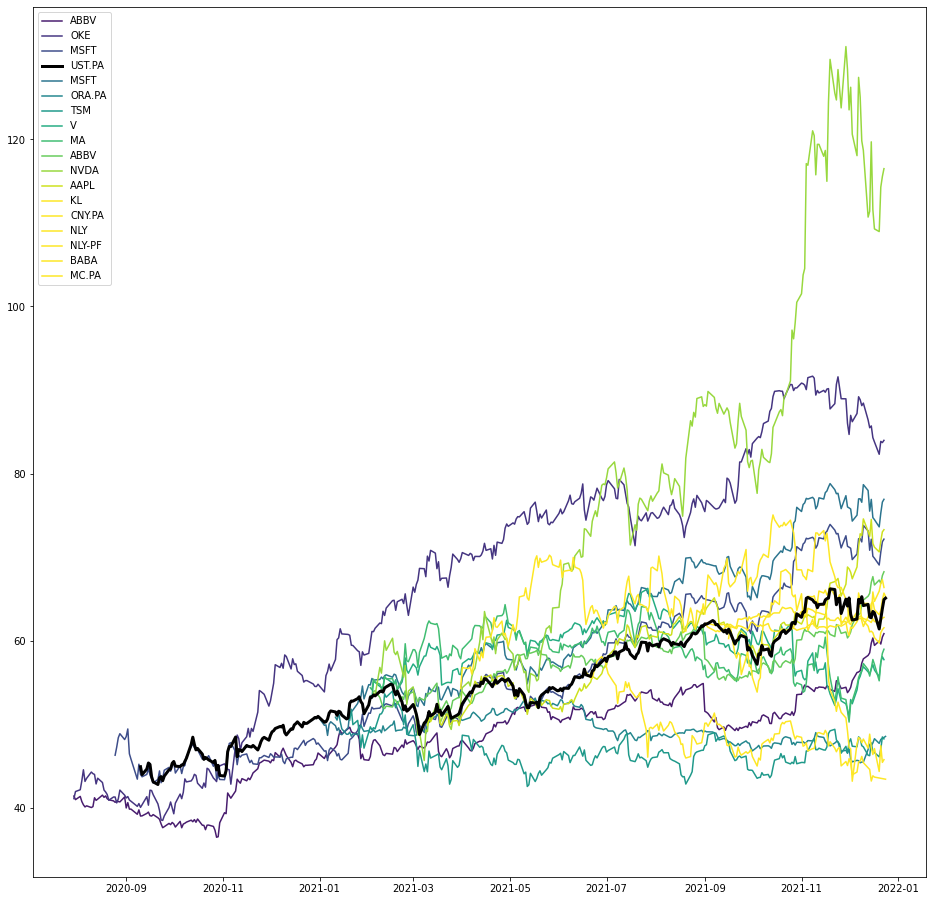

In [12]:
plt.figure(figsize=(16, 16))

ref_df = histories[ref_idx]

for i, (ticker_df, symbol) in enumerate(zip(histories, portfolio['Symbol'])): 
    try:
        trade_date = tradedate_2_dtime(portfolio.loc[i, 'Trade Date'])
    except ValueError:
        continue       
    T, P = scale_data(ticker_df, ref_df, trade_date, [])
    
    if i==ref_idx:
        print(symbol, trade_date, i)
        plt.plot(T, P, 'k', linewidth=3, zorder=5, label=symbol)
    else:
        plt.plot(T, P, label=symbol, color=cm.viridis(int(512*(i+1.)/len(portfolio))))
        


plt.legend()